# Brief description of the problem and data

In this project we attempt to create a binary classifier that will take in small image patches that are a part of larger digital pathology scans, and will output 1 if metastatic cancer was found in that patch, or 0 otherwise.

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.
Tumor tissue in the outer region of the patch does not influence the label.

The data provided is composed of 3 channel rgb images that are 96x96 pixels, and the training set size is around 220k images.

# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

import os

from tqdm import tqdm
from PIL import Image

dbg = False # When debugging the training set will be smaller

In [2]:
TRAIN_DIR = "/kaggle/input/histopathologic-cancer-detection/train"
TEST_DIR = "/kaggle/input/histopathologic-cancer-detection/test"
CONVERTED_TRAIN_DIR = "/kaggle/working/train/"
CONVERTED_TEST_DIR = "/kaggle/working/test/"

In [3]:
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [5]:
labels_df = labels_df.set_index('id')

## How are the classes distributed?

<Axes: >

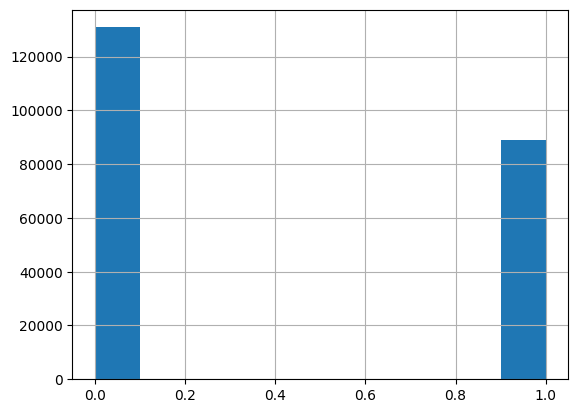

In [6]:
labels_df['label'].hist()

It seems like the classes are imbalanced, we will want to address that by intializing a similar bias in our output layer


In [7]:
pos = (labels_df['label'] == 1).sum()
neg = (labels_df['label'] == 0).sum()
initial_bias = np.log([pos/neg])
initial_bias


array([-0.38454467])

## Loading the images

### Converting tif to png

In [8]:
def convert_images(source_dir, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Loop through all files in the source directory
    for filename in tqdm(os.listdir(source_dir)):
        if filename.endswith('.tif'):
            # Construct full file paths
            tif_path = os.path.join(source_dir, filename)
            png_filename = os.path.splitext(filename)[0] + '.png'  # Change extension to .png
            png_path = os.path.join(output_dir, png_filename)
    
            # Open the TIFF file and save as PNG
            with Image.open(tif_path) as img:
                img.save(png_path, 'PNG')
    
            #print(f"Converted {filename} to {png_filename}")


In [9]:
# We already done that once, so commented out the conversion. converted data is loaded into inputs

# convert_images(TRAIN_DIR, CONVERTED_TRAIN_DIR)

### Arrange directory structure by classes

In [10]:
# import shutil

# # Make sure the destination class directories exist
# os.makedirs(os.path.join(CONVERTED_TRAIN_DIR, '0'), exist_ok=True)
# os.makedirs(os.path.join(CONVERTED_TRAIN_DIR, '1'), exist_ok=True)

# for id_, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
#     label = row['label']
#     src = os.path.join(CONVERTED_TRAIN_DIR, id_+".png")
#     dst = os.path.join(CONVERTED_TRAIN_DIR, str(label), id_+".png")
#     shutil.move(src, dst)

#### Upload converted dataset to save time on next executions

In [11]:
# !kaggle datasets init -p /kaggle/working/converted_cancer_images

In [12]:
# md = open("/kaggle/working/converted_cancer_images/dataset-metadata.json","r").read()

# md2 = md.replace("INSERT_SLUG_HERE","cancer-png-dataset").replace("INSERT_TITLE_HERE","Cancer dataset converted to PNG")

# f = open("/kaggle/working/converted_cancer_images/dataset-metadata.json","w")
# f.write(md2)
# f.close()

In [13]:
# !kaggle datasets create -p /kaggle/working/converted_cancer_images --dir-mode zip

In [14]:
# Override paths if loading previously converted dataset
CONVERTED_TRAIN_DIR = '/kaggle/input/cancer-png-dataset/train'

### Create data loader

In [15]:
%%time
training_images, validation_images = keras.utils.image_dataset_from_directory(CONVERTED_TRAIN_DIR, \
                                                           validation_split=0.2, \
                                                           seed=42, \
                                                           subset='both', \
                                                           image_size=(96,96)
                                                          )

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Using 44005 files for validation.
CPU times: user 11 s, sys: 7.92 s, total: 18.9 s
Wall time: 4min 47s


In [16]:
print(f"Training size: {training_images.cardinality()}")

Training size: 5501


Inspecting the samples to see what they look like

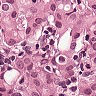

In [17]:
Image.open("/kaggle/input/cancer-png-dataset/train/1/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.png")

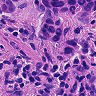

In [18]:
Image.open('/kaggle/input/cancer-png-dataset/train/1/0000da768d06b879e5754c43e2298ce48726f722.png')

# Architecture

The architecture I will be attempting to apply on this data is a convolutional neural network described by the following layers:


Rescaling 1/255 making sure all values are between 0-1

CenterCrop(32,32) - Given the task description, this is the only area of the image that matters for the label

3x3 convolution layer with 16 filters and stride of 1 (with padding)

2x2 max pooling layer

3x3 convolution layer with 32 filters and stride of 1 (with padding)

2x2 max pooling layer

3x3 convolution layer with 64 filters and stride of 1 (with padding)

2x2 max pooling layer





Followed by 3 fully connected dense layers of MLP:

Dense layer size = 1024 (dropout 0.2)

Dense layer size = 512 (dropout 0.2)

Dense layer size = 256 (dropout 0.2)

Output layer 1 unit with sigmoid activation (for binary classification), bias initialized according to class imbalance




The idea here is to start with simpler features and as the layer depth increase capture a larger amount of more complex features.

After the four convolution layers with pooling we will end up with a feature map which is then fed into the densely connected network which ends up with a single unit for the output layer.

The final activation should be sigmoid since we're working with binary classification.


#### Implementation

In [19]:
import keras
from keras import layers

epochs = 20
steps_per_epoch = len(training_images) # For learning rate decay calculation


def make_model(input_shape, num_classes, fc_layers, dropout_rate, initial_learning_rate, final_learning_rate):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.CenterCrop(32,32)(x) # Given the task description
    
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2, strides=2)(x)


    x = layers.Flatten()(x)

    for layer_sz in fc_layers:
        x = layers.Dense(layer_sz, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(1, activation="sigmoid", bias_initializer=keras.initializers.Constant(initial_bias))(x)
    model = keras.Model(inputs, outputs)
    
    
    learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
      
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=steps_per_epoch, decay_rate=learning_rate_decay_factor, staircase=True
    )
    
    
    METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

    return model




### Trying out different architectures and with different hyper-parameters

In [20]:
models  = [
    make_model((96,96,3), 1, [1024,512,256],  0.2, 1e-3, 1e-3), # AUC 0.8487425621795471, 0.91
    make_model((96,96,3), 1, [1024,512,256],  0.2, 1e-3, 1e-4),
    make_model((96,96,3), 1, [1024,512,256],  0.2, 1e-3, 1e-5),
]


In [21]:
checkpoint_cb = [keras.callbacks.ModelCheckpoint(f"cancer_model_{n}.keras", save_best_only=True) for n in range(len(models))]

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True
)

In [22]:
if dbg:
    training_images = training_images.take(1000) # DBG
    validation_images = validation_images.take(1000) # DBG

histories = []
for n,model in enumerate(models):
    model.summary()
    
    histories += [model.fit(
        training_images,
        validation_data=validation_images,
        epochs=epochs,
        callbacks=[early_stopping_cb, checkpoint_cb[n]],
    )]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ center_crop (CenterCrop)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             2

 Total params: 1,736,737 (6.63 MB)

 Trainable params: 1,733,153 (6.61 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 338s 60ms/step - binary_accuracy: 0.7546 - loss: 0.5264 - precision: 0.7159 - recall: 0.6562 - val_binary_accuracy: 0.7307 - val_loss: 0.5513 - val_precision: 0.8616 - val_recall: 0.3948
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - binary_accuracy: 0.7911 - loss: 0.4609 - precision: 0.7743 - recall: 0.6852 - val_binary_accuracy: 0.7816 - val_loss: 0.4792 - val_precision: 0.7274 - val_recall: 0.7321
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - binary_accuracy: 0.7994 - loss: 0.4489 - precision: 0.7821 - recall: 0.7010 - val_binary_accuracy: 0.7521 - val_loss: 0.5227 - val_precision: 0.8934 - val_recall: 0.4365
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - binary_accuracy: 0.8030 - loss: 0.4392 - precision: 0.7848 - recall: 0.7092 - val_binary_accuracy: 0.7645 - val_loss: 0.5095 - val_precision: 0.6616 - val_recall: 0.8499
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - binary_accuracy: 0.8093 - los

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ center_crop_1 (CenterCrop)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             2

 Total params: 1,736,737 (6.63 MB)

 Trainable params: 1,733,153 (6.61 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 93s 16ms/step - binary_accuracy: 0.7596 - loss: 0.5176 - precision: 0.7252 - recall: 0.6573 - val_binary_accuracy: 0.6236 - val_loss: 0.6728 - val_precision: 0.5345 - val_recall: 0.5068
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - binary_accuracy: 0.7960 - loss: 0.4536 - precision: 0.7799 - recall: 0.6929 - val_binary_accuracy: 0.6931 - val_loss: 0.7118 - val_precision: 0.9203 - val_recall: 0.2605
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - binary_accuracy: 0.8041 - loss: 0.4398 - precision: 0.7889 - recall: 0.7064 - val_binary_accuracy: 0.7947 - val_loss: 0.4559 - val_precision: 0.7974 - val_recall: 0.6570
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - binary_accuracy: 0.8100 - loss: 0.4293 - precision: 0.7940 - recall: 0.7185 - val_binary_accuracy: 0.8049 - val_loss: 0.4462 - val_precision: 0.8040 - val_recall: 0.6816
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - binary_accuracy: 0.8155 - loss

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ center_crop_2 (CenterCrop)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             2

 Total params: 1,736,737 (6.63 MB)

 Trainable params: 1,733,153 (6.61 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 92s 16ms/step - binary_accuracy: 0.7601 - loss: 0.5167 - precision: 0.7252 - recall: 0.6597 - val_binary_accuracy: 0.6902 - val_loss: 0.6319 - val_precision: 0.9372 - val_recall: 0.2474
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - binary_accuracy: 0.7968 - loss: 0.4519 - precision: 0.7793 - recall: 0.6969 - val_binary_accuracy: 0.6915 - val_loss: 0.7366 - val_precision: 0.8887 - val_recall: 0.2675
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - binary_accuracy: 0.8043 - loss: 0.4372 - precision: 0.7882 - recall: 0.7079 - val_binary_accuracy: 0.7859 - val_loss: 0.4742 - val_precision: 0.8772 - val_recall: 0.5445
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - binary_accuracy: 0.8114 - loss: 0.4247 - precision: 0.7942 - recall: 0.7223 - val_binary_accuracy: 0.7750 - val_loss: 0.4911 - val_precision: 0.6690 - val_recall: 0.8739
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - binary_accuracy: 0.8171 - loss

# Results

### Model Performance

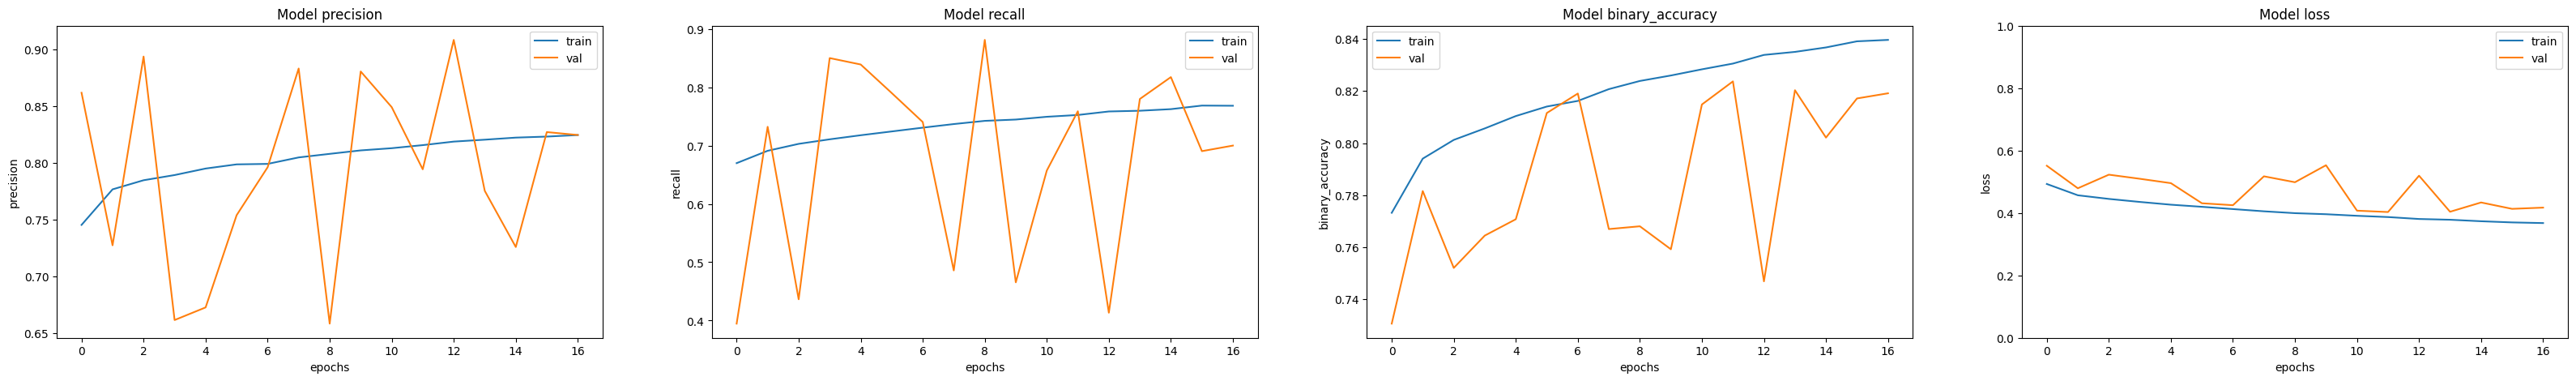

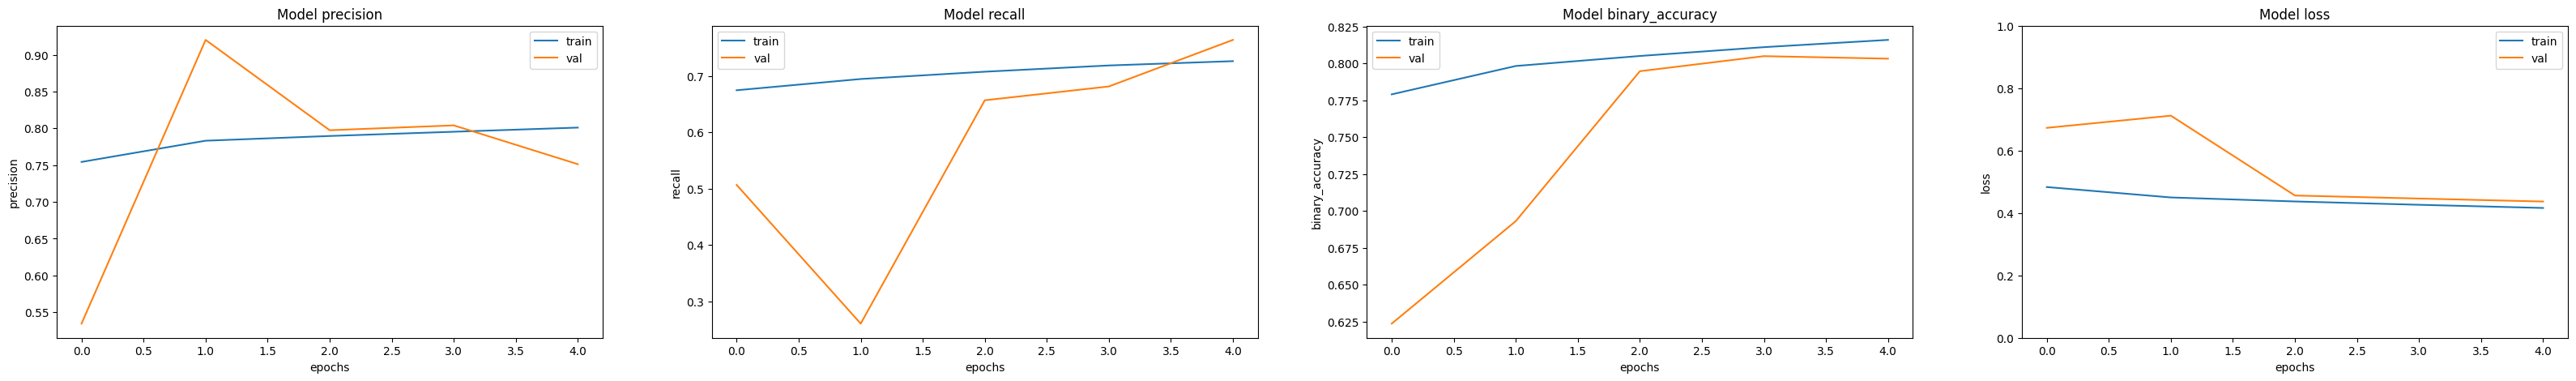

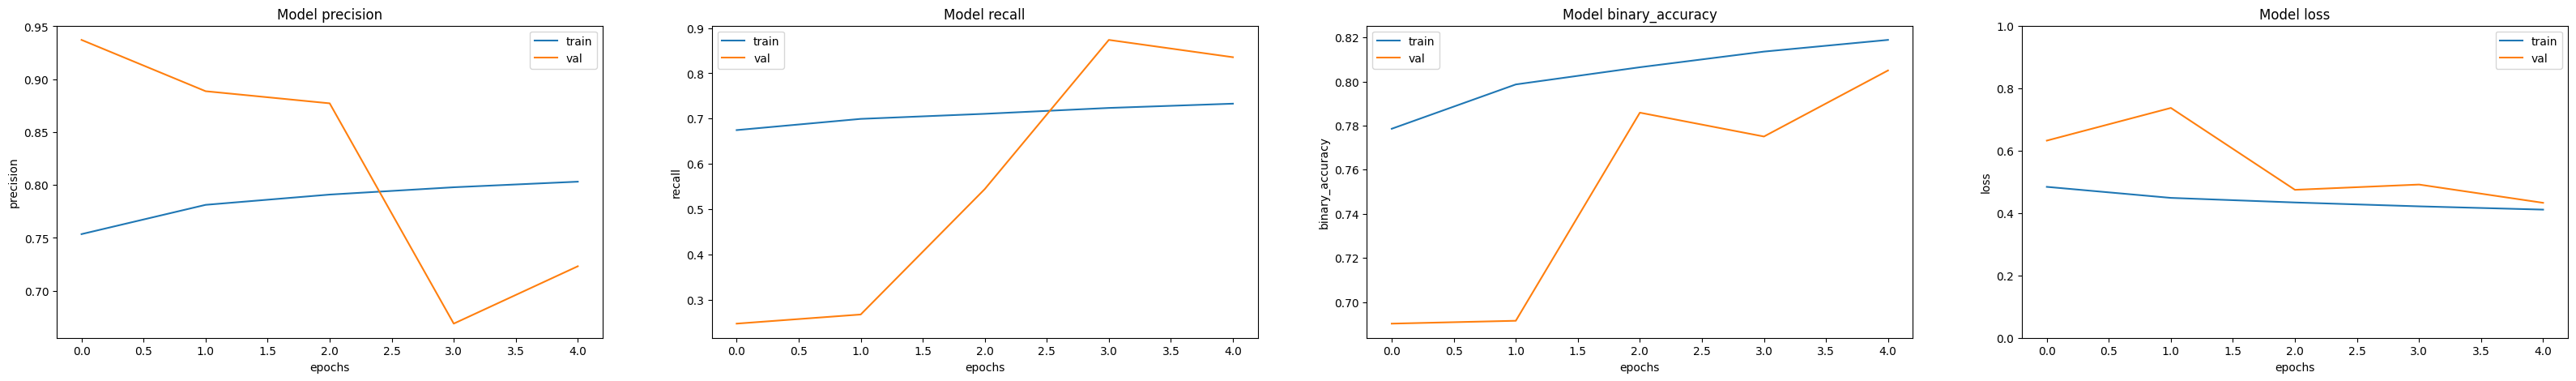

In [23]:
import matplotlib.pyplot as plt

for n,history in enumerate(histories):
    fig, ax = plt.subplots(1, 4, figsize=(40, 5))
    ax = ax.ravel()
    
    for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history["val_" + met])
        ax[i].set_title("Model {}".format(met))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(met)
        ax[i].legend(["train", "val"])
        if met == 'loss':
            ax[i].set_ylim(0, 1)  # Limit the y-axis from 0 to 1

    
    plt.savefig(f"metrics_{str(n)}.png")


### Predicting on test set


In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
true_labels = y = np.concatenate([y for x, y in validation_images], axis=0)

aucs=[]
for i, model in enumerate(models):
    predictions = model.predict(validation_images)
    aucs += [roc_auc_score(true_labels, predictions)]
    print(f"Model {str(i)} has ROC AUC of {aucs[i]}")

# Choose best model for submission
model = models[np.argmax(aucs)]
    
    
    
    

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step
Model 0 has ROC AUC of 0.891527437137695
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
Model 1 has ROC AUC of 0.69971280304866
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step
Model 2 has ROC AUC of 0.8607671046850254


### Submission

In [26]:
convert_images(TEST_DIR, CONVERTED_TEST_DIR) # This one we have to do every submission

testing_images = keras.utils.image_dataset_from_directory(CONVERTED_TEST_DIR, \
                                                          labels=None, \
                                                          image_size=(96,96),
                                                          shuffle=False
                                                          )

test_paths = testing_images.file_paths

100%|██████████| 57458/57458 [06:58<00:00, 137.40it/s]


Found 57458 files.


In [27]:
#testing_images = testing_images.take(10) #DBG
predictions = model.predict(testing_images)

predictions = 1*(predictions>0.5)

submission_df = pd.DataFrame(zip(test_paths, predictions.reshape(-1)), columns=['id','label'])

submission_df['id'] = submission_df['id'].apply(lambda x: os.path.basename(x)[:-4])

submission_df = submission_df.set_index('id')

submission_df.to_csv("submission.csv")

!head submission.csv

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step
id,label
00006537328c33e284c973d7b39d340809f7271b,1
0000ec92553fda4ce39889f9226ace43cae3364e,1
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
000253dfaa0be9d0d100283b22284ab2f6b643f6,1
000270442cc15af719583a8172c87cd2bd9c7746,0
000309e669fa3b18fb0ed6a253a2850cce751a95,0
000360e0d8358db520b5c7564ac70c5706a0beb0,0
00040095a4a671280aeb66cb0c9231e6216633b5,0
000698b7df308d75ec9559ef473a588c513a68aa,0


# Conclusions

Working with the images dataset was difficult mainly due to low resources and each iteration taking a very long time. Another challenge was working with the images format, which led me to creating a converted dataset in a different format that is more easily read by keras.

In general it seems like some decent results were achieved (score around 0.75), with a basic convolutional neural network.

It did take a lot of trial and error to find an architecture that works well, which was eventually automated, and in addition several hyper-parameters were also needed to be tuned.

In the future I'd like to try some other known architecture like ResNet, and maybe experiment with vision transformers as well.
